In [1]:
from pathlib import Path
import pandas as pd
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_DIR = Path("ollama/outputs/meta-llama__Llama-3.2-3B-Instruct-6_epocas/final")  # carpeta del modelo entrenado
DATASET_CSV = Path("../data/pls_abstract_pairs_with_metrics.csv")  # ruta  dataset
SPLIT = "train"  # 'train' o 'test'

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [4]:
df = pd.read_csv(DATASET_CSV)
assert "source_text" in df.columns, "El CSV debe tener una columna 'source_text'"
texts = df["source_text"].astype(str).tolist()

# Opcional: si tu dataset tiene 'split' (train/validation)
if "split" in df.columns:
    df = df[df["split"] == SPLIT].reset_index(drop=True)
    texts = df["source_text"].astype(str).tolist()

print(f"Ejemplos en '{SPLIT}':", len(texts))

Ejemplos en 'train': 3578


In [5]:
lengths = [len(tokenizer(text).input_ids) for text in texts]

arr = np.array(lengths)
percentiles = np.percentile(arr, [50, 90, 95, 99])
above_768 = np.mean(arr > 768) * 100
above_1024 = np.mean(arr > 1024) * 100

In [6]:
print("\nDistribución de longitudes (tokens):")
print(f"P50 : {percentiles[0]:.0f}")
print(f"P90 : {percentiles[1]:.0f}")
print(f"P95 : {percentiles[2]:.0f}")
print(f"P99 : {percentiles[3]:.0f}")
print(f">768 : {above_768:.2f}%")
print(f">1024: {above_1024:.2f}%")


Distribución de longitudes (tokens):
P50 : 1047
P90 : 1527
P95 : 1643
P99 : 1823
>768 : 77.81%
>1024: 52.77%


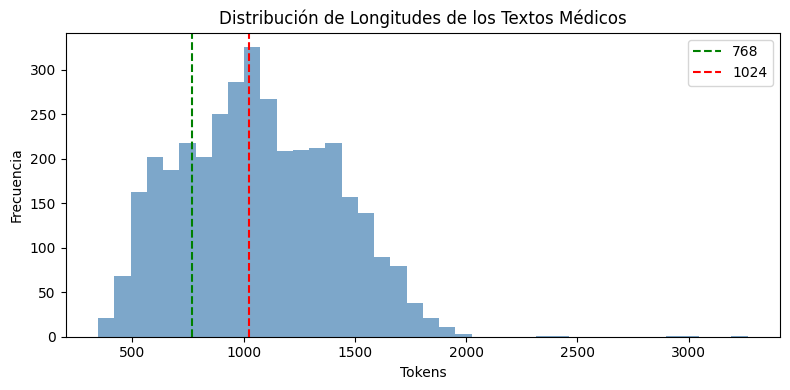

In [9]:
plt.figure(figsize=(8,4))
plt.hist(arr, bins=40, color="steelblue", alpha=0.7)
plt.axvline(768, color="green", linestyle="--", label="768")
plt.axvline(1024, color="red", linestyle="--", label="1024")
plt.title(f"Distribución de Longitudes de los Textos Médicos") #({SPLIT})")
plt.xlabel("Tokens")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()